# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go

import dask.dataframe as dd

import gc

import pyarrow

In [2]:
dataset_path = '/kaggle/input/sncb-data-augumentation/enriched_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")
    
data = data.drop(['Unnamed: 0', 'dayofweek', 'datetime', 'date_hour'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   timestamps_UTC      object 
 2   mapped_veh_id       float64
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
 15  date                object 
 16  hour                float64
 17  dayofweek           float64
 18  weekday             object 
 19  Distance            float64
 20  Speed               float64
 21  date_hour           object 
 22  datetime            object 
 23  weather_main        object 
 24  temp                fl

# Statistical methods to Label

In [3]:
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

In [4]:
# Convert timestamps to datetime and sort
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
data = data.sort_values('timestamps_UTC')

# Calculate time differences in minutes
data['time_diff'] = data['timestamps_UTC'].diff().dt.total_seconds() / 60.0

# Identify rows where the vehicle is stopped
data['is_stopped'] = data['Speed'] < stopped_threshold

# Forward-fill the 'is_stopped' status only within the groups where the vehicle is stopped
data['stopped_group'] = data['is_stopped'].ne(data['is_stopped'].shift()).cumsum()
data.loc[data['is_stopped'], 'stopped_group'] = data.loc[data['is_stopped'], 'stopped_group']

# Calculate the cumulative stopped time in minutes only for stopped groups
data['cumulative_stopped_time'] = data.groupby('stopped_group')['time_diff'].cumsum().fillna(0)

# Determine the stopped groups that exceed the minimum stopped duration
stopped_groups = data[data['cumulative_stopped_time'] > minimum_stopped_minutes]['stopped_group'].unique()

# Mark the status based on the identified stopped groups
data['status'] = 'running'
data.loc[data['stopped_group'].isin(stopped_groups), 'status'] = 'stopped'


In [5]:
data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,humidity,wind,clouds,temp_celsius,feels_like_celsius,time_diff,is_stopped,stopped_group,cumulative_stopped_time,status
10309566,2023-01-23 02:29:50,160.0,51.04,3.69,14.0,15.0,6.0,27.0,802.0,804.0,...,90.0,2.62,100.0,1.34,-1.55,NaN,True,1,0.000000,stopped
10309567,2023-01-23 02:30:49,160.0,51.04,3.69,14.0,25.0,6.0,24.0,802.0,804.0,...,92.0,2.65,100.0,1.42,-1.48,0.983333,True,1,0.983333,stopped
10309568,2023-01-23 02:31:50,160.0,51.04,3.69,20.0,30.0,6.0,24.0,802.0,804.0,...,92.0,2.65,100.0,1.42,-1.48,1.016667,True,1,2.000000,stopped
479843,2023-01-23 02:50:41,106.0,50.41,4.52,41.0,41.0,6.0,3.0,802.0,804.0,...,99.0,3.60,75.0,0.03,-3.96,18.850000,True,1,20.850000,stopped
479844,2023-01-23 02:50:48,106.0,50.41,4.52,41.0,41.0,3.0,3.0,802.0,804.0,...,99.0,3.60,75.0,0.03,-3.96,0.116667,True,1,20.966667,stopped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319481,2023-09-13 21:51:55,115.0,50.14,4.50,38.0,36.0,182.0,213.0,802.0,800.0,...,88.0,1.03,75.0,13.68,13.40,0.550000,True,15297,24.583333,running
16731733,2023-09-13 21:51:57,191.0,51.15,4.61,36.0,37.0,424.0,420.0,1501.0,1500.0,...,84.0,1.03,100.0,13.70,13.32,0.033333,True,15297,24.616667,running
3190108,2023-09-13 21:52:16,120.0,50.15,4.50,37.0,31.0,196.0,241.0,801.0,797.0,...,88.0,1.03,75.0,13.68,13.40,0.316667,True,15297,24.933333,running
17418908,2023-09-13 21:52:22,196.0,50.42,4.54,18.0,23.0,690.0,300.0,800.0,795.0,...,92.0,2.57,20.0,14.30,14.19,0.100000,True,15297,25.033333,running


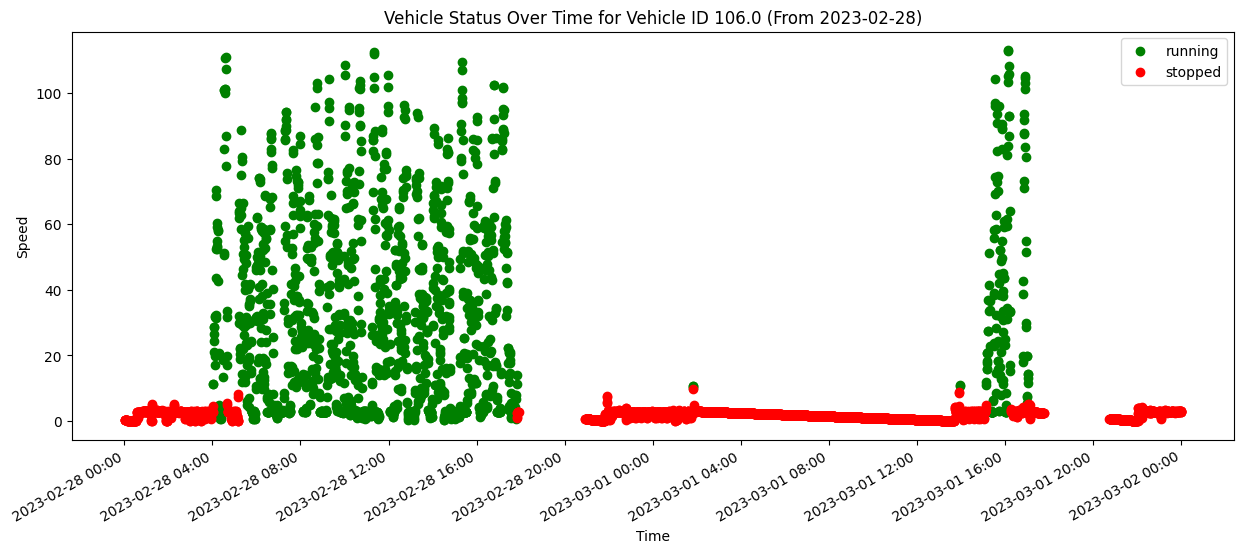

In [6]:
# Define the threshold for a vehicle being stopped and the duration
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

# Select a specific vehicle ID
specific_veh_id = data['mapped_veh_id'].unique()[1]  
veh_data = data[data['mapped_veh_id'] == specific_veh_id]

# Define the start and end dates for the week you want to display
week_start = pd.to_datetime("2023-02-28")  # Example start date
week_end = week_start + pd.Timedelta(days=2)  # Two days later

# Filter the data for that period
week_data = veh_data[(veh_data['timestamps_UTC'] >= week_start) & (veh_data['timestamps_UTC'] < week_end)]

# Create the plot
plt.figure(figsize=(15, 6))

# Use different colors for running and stopped status
for status, color in [('running', 'green'), ('stopped', 'red')]:
    status_data = week_data[week_data['status'] == status]
    plt.scatter(status_data['timestamps_UTC'], status_data['Speed'], color=color, label=status)

# Set the legend
plt.legend()

# Set the chart title and axis labels
plt.title(f"Vehicle Status Over Time for Vehicle ID {specific_veh_id} (From {week_start.strftime('%Y-%m-%d')})")
plt.xlabel("Time")
plt.ylabel("Speed")

# Format the x-axis to better display dates and times
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gcf().autofmt_xdate()  # Automatically rotate date labels to prevent overlap

# Show the plot
plt.show()

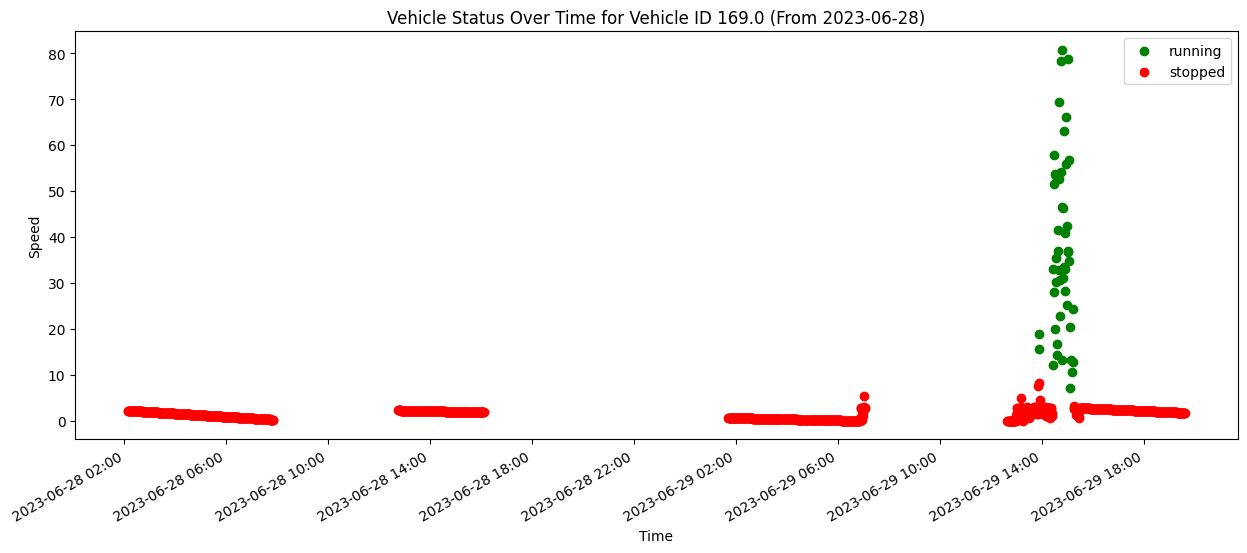

In [7]:
# Define the threshold for a vehicle being stopped and the duration
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

# Select a specific vehicle ID
specific_veh_id = data['mapped_veh_id'].unique()[50] 
veh_data = data[data['mapped_veh_id'] == specific_veh_id]

# Define the start and end dates for the week you want to display
week_start = pd.to_datetime("2023-06-28")  # Example start date
week_end = week_start + pd.Timedelta(days=2)  # Two days later

# Filter the data for that period
week_data = veh_data[(veh_data['timestamps_UTC'] >= week_start) & (veh_data['timestamps_UTC'] < week_end)]

# Create the plot
plt.figure(figsize=(15, 6))

# Use different colors for running and stopped status
for status, color in [('running', 'green'), ('stopped', 'red')]:
    status_data = week_data[week_data['status'] == status]
    plt.scatter(status_data['timestamps_UTC'], status_data['Speed'], color=color, label=status)

# Set the legend
plt.legend()

# Set the chart title and axis labels
plt.title(f"Vehicle Status Over Time for Vehicle ID {specific_veh_id} (From {week_start.strftime('%Y-%m-%d')})")
plt.xlabel("Time")
plt.ylabel("Speed")

# Format the x-axis to better display dates and times
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gcf().autofmt_xdate()  # Automatically rotate date labels to prevent overlap

# Show the plot
plt.show()

In [8]:
data = data.drop(['stopped_group', 'is_stopped', 'time_diff'], axis=1)

## Naive Label Anomalous Spot

In [9]:
def label_data(df):
    condition = (
        (df['RS_E_InAirTemp_PC1'] > 65) | (df['RS_E_InAirTemp_PC2'] > 65) |
        (df['RS_E_WatTemp_PC1'] > 100) | (df['RS_E_WatTemp_PC2'] > 100) |
        (df['RS_T_OilTemp_PC1'] > 115) | (df['RS_T_OilTemp_PC2'] > 115)
    )


    df['engine_error_label'] = 0
    df.loc[condition, 'engine_error_label'] = 1

    return df

data = label_data(data)
data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,feels_like,pressure,humidity,wind,clouds,temp_celsius,feels_like_celsius,cumulative_stopped_time,status,engine_error_label
10309566,2023-01-23 02:29:50,160.0,51.04,3.69,14.0,15.0,6.0,27.0,802.0,804.0,...,271.60,1034.0,90.0,2.62,100.0,1.34,-1.55,0.000000,stopped,0
10309567,2023-01-23 02:30:49,160.0,51.04,3.69,14.0,25.0,6.0,24.0,802.0,804.0,...,271.67,1034.0,92.0,2.65,100.0,1.42,-1.48,0.983333,stopped,0
10309568,2023-01-23 02:31:50,160.0,51.04,3.69,20.0,30.0,6.0,24.0,802.0,804.0,...,271.67,1034.0,92.0,2.65,100.0,1.42,-1.48,2.000000,stopped,0
479843,2023-01-23 02:50:41,106.0,50.41,4.52,41.0,41.0,6.0,3.0,802.0,804.0,...,269.19,1033.0,99.0,3.60,75.0,0.03,-3.96,20.850000,stopped,0
479844,2023-01-23 02:50:48,106.0,50.41,4.52,41.0,41.0,3.0,3.0,802.0,804.0,...,269.19,1033.0,99.0,3.60,75.0,0.03,-3.96,20.966667,stopped,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319481,2023-09-13 21:51:55,115.0,50.14,4.50,38.0,36.0,182.0,213.0,802.0,800.0,...,286.55,1022.0,88.0,1.03,75.0,13.68,13.40,24.583333,running,0
16731733,2023-09-13 21:51:57,191.0,51.15,4.61,36.0,37.0,424.0,420.0,1501.0,1500.0,...,286.47,1022.0,84.0,1.03,100.0,13.70,13.32,24.616667,running,0
3190108,2023-09-13 21:52:16,120.0,50.15,4.50,37.0,31.0,196.0,241.0,801.0,797.0,...,286.55,1022.0,88.0,1.03,75.0,13.68,13.40,24.933333,running,0
17418908,2023-09-13 21:52:22,196.0,50.42,4.54,18.0,23.0,690.0,300.0,800.0,795.0,...,287.34,1023.0,92.0,2.57,20.0,14.30,14.19,25.033333,running,0


# Random Forest

In [10]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])

# Define features and target variable
features = ['mapped_veh_id', 'lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2',
            'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2',
            'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2',
            'hour', 'Distance', 'Speed', 'weather_main', 'temp_celsius', 'feels_like_celsius',
            'pressure', 'humidity', 'wind', 'clouds', 'weekday']

target = 'engine_error_label'

# Separate features and target variable
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical columns
numeric_columns = ['mapped_veh_id', 'lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2',
                   'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2',
                   'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2',
                   'hour', 'Distance', 'Speed', 'temp_celsius', 'feels_like_celsius',
                   'pressure', 'humidity', 'wind', 'clouds']

categorical_columns = ['weather_main', 'weekday']

# Convert numeric columns to float32
for col in numeric_columns:
    X.loc[:, col] = X[col].astype('float32')

In [11]:
# Create transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Create a pipeline that combines preprocessing and modeling steps
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', rf_classifier)])

# Train the classifier on the training data
# Train the model in batches
# Batch processing with multiple epochs
num_epochs = 2  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Iterate over batches
    chunk_size = 250000 #Lower the number of batches if the RAM goes too high
    for i in range(0, len(X_train), chunk_size):
        model.fit(X_train.iloc[i:i+chunk_size], y_train.iloc[i:i+chunk_size])

    # Evaluate the model on the testing set after each epoch
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy after epoch {epoch + 1}: {accuracy}')

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional evaluation metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.9999072258609044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3519411
           1       1.00      0.98      0.99     16057

    accuracy                           1.00   3535468
   macro avg       1.00      0.99      0.99   3535468
weighted avg       1.00      1.00      1.00   3535468



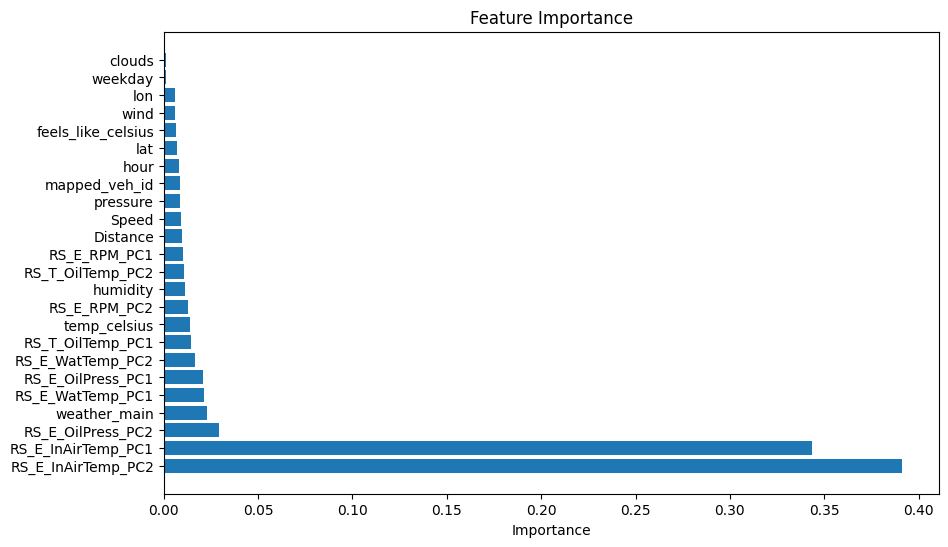

In [19]:
# Get feature importances
feature_importances = model.named_steps['classifier'].feature_importances_

# Ensure lengths are aligned by trimming the feature importances
feature_importances = feature_importances[:len(X.columns)]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort and plot the feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

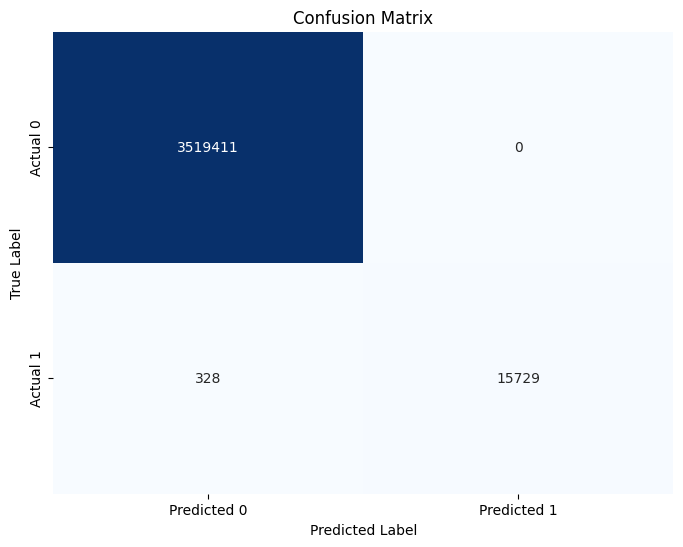

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Get indices of false positive and false negative instances
false_positive_indices = (y_test == 0) & (y_pred == 1)
false_negative_indices = (y_test == 1) & (y_pred == 0)

# Access the corresponding data for analysis
false_positive_data = X_test[false_positive_indices]
false_negative_data = X_test[false_negative_indices]

# Descriptive statistics for false positive instances
print("False Positive Data Statistics:")
print(false_positive_data.describe())

# Descriptive statistics for false negative instances
print("\nFalse Negative Data Statistics:")
print(false_negative_data.describe())

False Positive Data Statistics:
       mapped_veh_id  lat  lon  RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  \
count            0.0  0.0  0.0                 0.0                 0.0   
mean             NaN  NaN  NaN                 NaN                 NaN   
std              NaN  NaN  NaN                 NaN                 NaN   
min              NaN  NaN  NaN                 NaN                 NaN   
25%              NaN  NaN  NaN                 NaN                 NaN   
50%              NaN  NaN  NaN                 NaN                 NaN   
75%              NaN  NaN  NaN                 NaN                 NaN   
max              NaN  NaN  NaN                 NaN                 NaN   

       RS_E_OilPress_PC1  RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  \
count                0.0                0.0           0.0           0.0   
mean                 NaN                NaN           NaN           NaN   
std                  NaN                NaN           NaN           NaN   
m

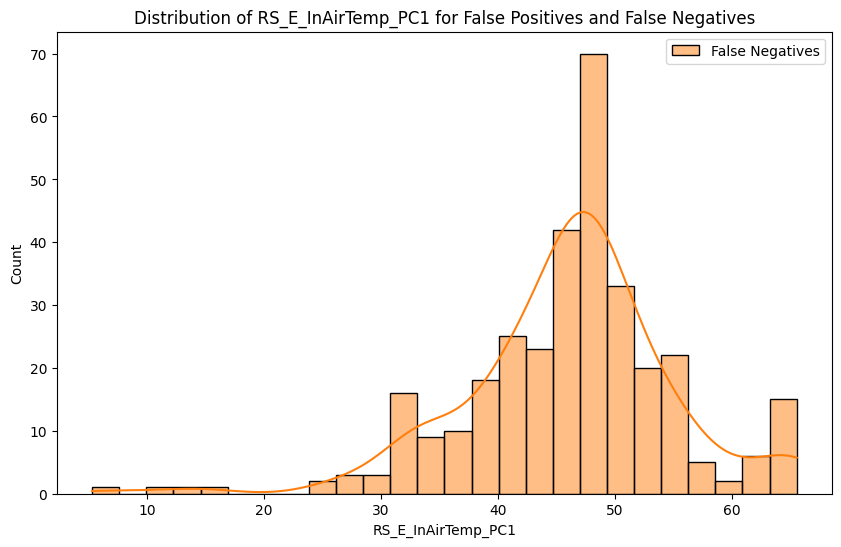

In [28]:
# Specify a feature present in your dataset
feature_of_interest = 'RS_E_InAirTemp_PC1'

plt.figure(figsize=(10, 6))
sns.histplot(false_positive_data[feature_of_interest], label='False Positives', kde=True)
sns.histplot(false_negative_data[feature_of_interest], label='False Negatives', kde=True)
plt.title(f'Distribution of {feature_of_interest} for False Positives and False Negatives')
plt.legend()
plt.show()

In [29]:
data.to_csv('labeled_augumented_RF_cleaned_ar41_for_ulb.csv', index=True)

## Correlations Graph

In [ ]:
# Load the large dataset using Dask for efficient handling of large data
ddf = dd.read_csv('/kaggle/input/sncb-data-augumentation/enriched_cleaned_ar41_for_ulb.csv')

# Convert the Dask DataFrame to a Pandas DataFrame with a sample for initial exploration
# Adjust the fraction as needed for the size of your dataset
df_sample = ddf.sample(frac=0.001).compute()

# Perform one-hot encoding on the 'weather_main' and 'status' categorical columns
weather_dummies = pd.get_dummies(df_sample['weather_main'], prefix='weather')
# status_dummies = pd.get_dummies(df_sample['status'], prefix='status')

# Add the one-hot encoded columns to the original DataFrame
df_sample = pd.concat([df_sample, weather_dummies], axis=1)

# Drop the original categorical columns to avoid duplication
# df_sample.drop(['weather_main', 'status'], axis=1, inplace=True)
df_sample.drop(['weather_main'], axis=1, inplace=True)

# Reset the index of the DataFrame to avoid issues with seaborn plotting
df_sample = df_sample.reset_index(drop=True)

# Select only numeric columns from the original Dask DataFrame for correlation analysis
ddf_numeric = ddf.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = ddf_numeric.corr().compute()

# Create a pairplot for the sample data
sns.pairplot(df_sample)
plt.show()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Save to CSV

In [ ]:
data.to_csv('labeled_augumented_cleaned_ar41_for_ulb.csv', index=True)